In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:

import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [73]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Train.csv']))

In [6]:
df.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [7]:
df.isna().sum()

ID                0
comment           0
date              0
down              0
parent_comment    0
score             0
top               0
topic             0
user              0
label             0
dtype: int64

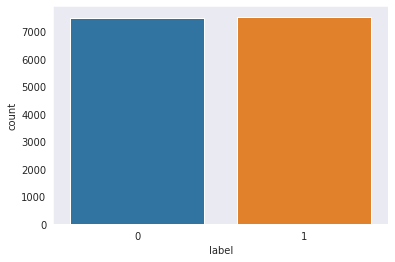

In [8]:
sns.set_style("dark")
sns.countplot(df.label)

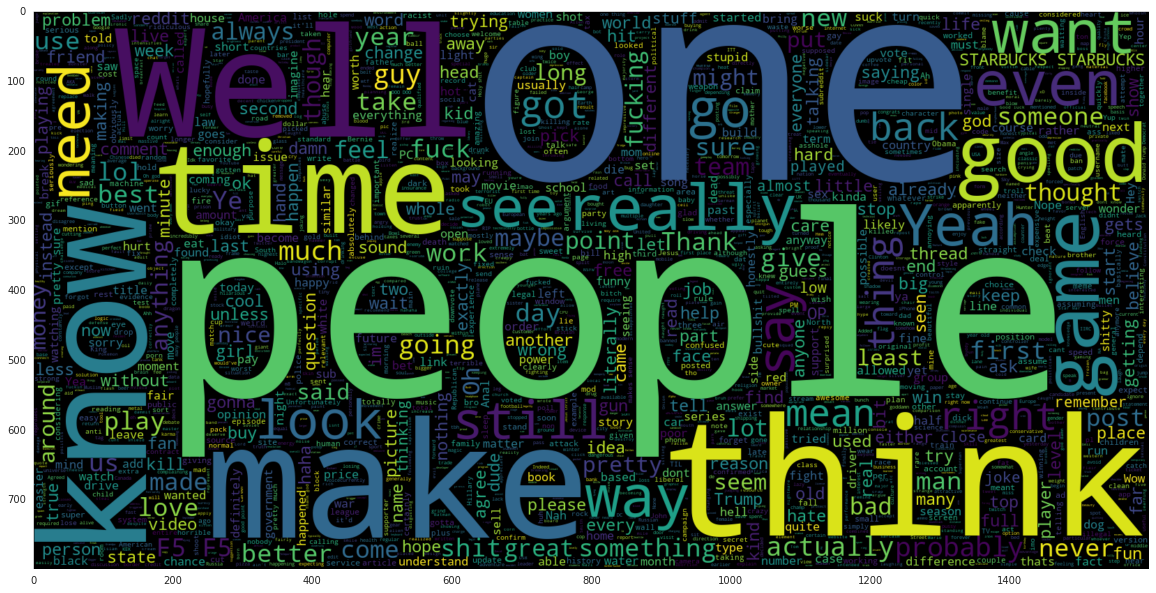

In [17]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].comment))
plt.imshow(wc , interpolation = 'bilinear')

In [18]:
df['parent_comment']=df['parent_comment'].apply(denoise_text)

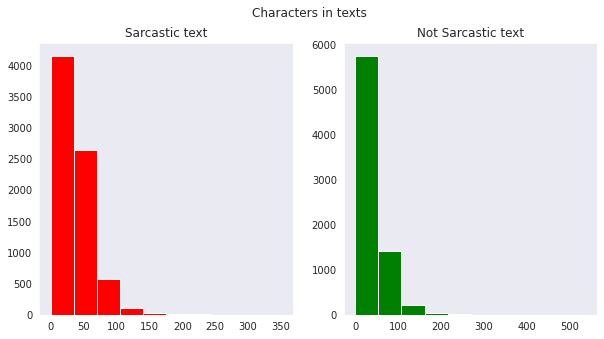

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['label']==1]['comment'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['label']==0]['comment'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

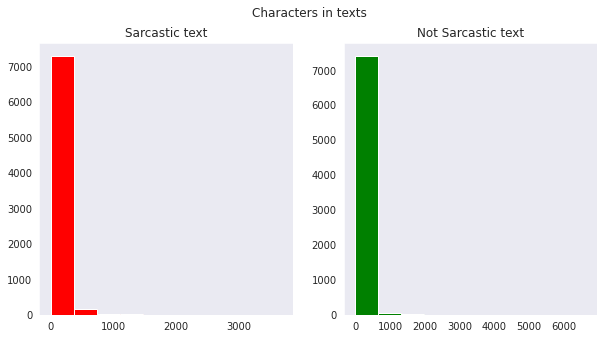

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['label']==1]['parent_comment'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['label']==0]['parent_comment'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

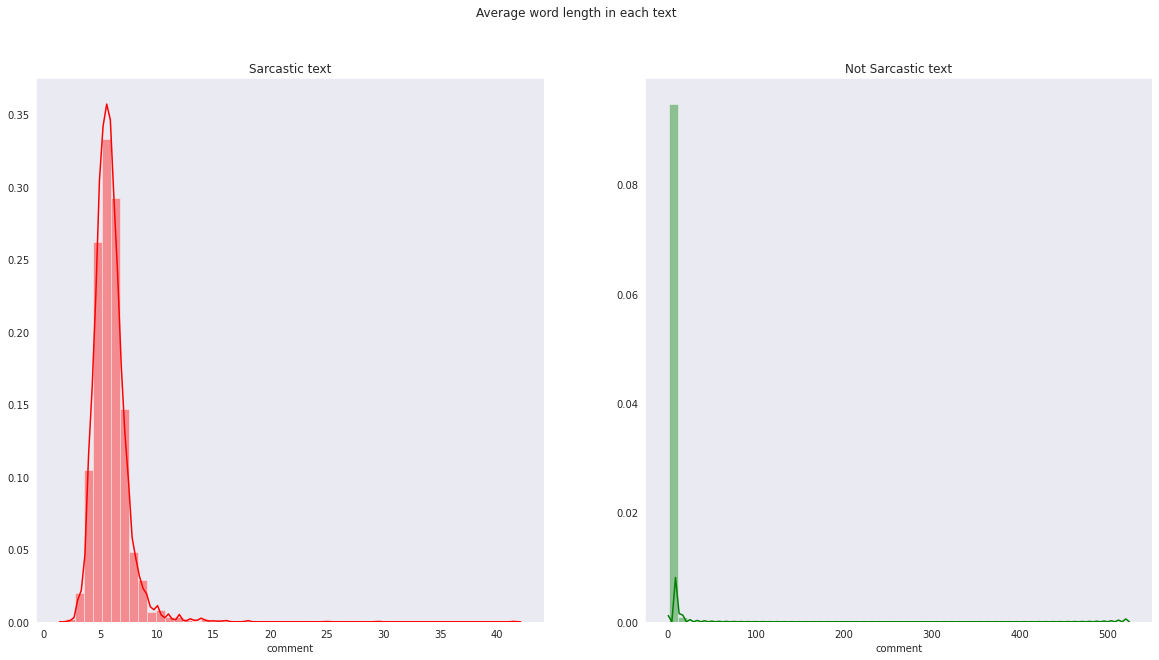

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['label']==1]['comment'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['label']==0]['comment'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [65]:
sub_df = df.groupby('topic')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
topic,,,
worldnews,399,0.671679,268
politics,572,0.624126,357
leagueoflegends,331,0.589124,195
AskReddit,942,0.393843,371


In [66]:
sub_df = df[df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,854,0.606557,518
4,641,0.555382,356
6,444,0.545045,242
7,337,0.543027,183
2,2323,0.502368,1167
5,580,0.500000,290
3,1362,0.485316,661
1,5029,0.433287,2179


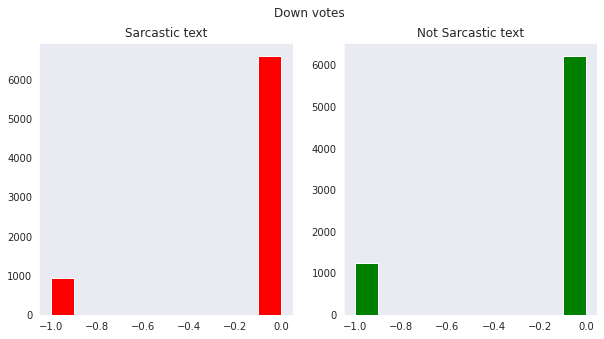

In [72]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['label']==1]['down']
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['label']==0]['down']
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Down votes')
plt.show()

In [74]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(df['comment'], df['label'], random_state=17)

In [75]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [76]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 505 ms, sys: 56.2 ms, total: 561 ms
Wall time: 1.9 s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.3s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [77]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 88 ms, sys: 939 µs, total: 88.9 ms
Wall time: 95.1 ms


In [78]:
accuracy_score(y_valid, valid_pred)

0.6426666666666667

In [79]:
f1_score(y_valid, valid_pred)

0.6271563717306623

In [33]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

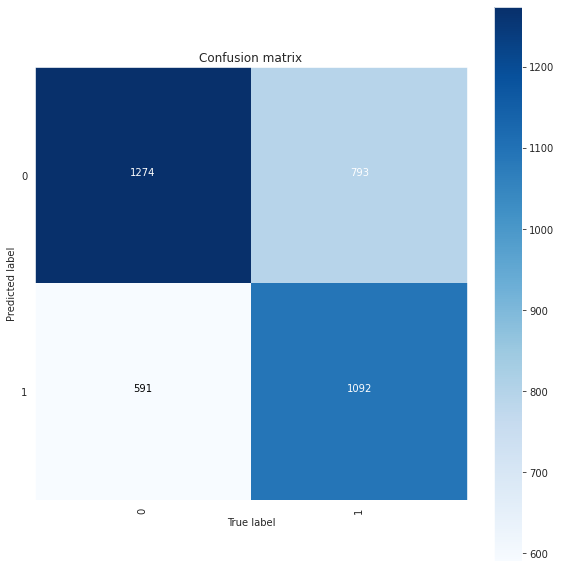

In [34]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [80]:
subreddits = df['topic']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [81]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

In [82]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 566 ms, sys: 10.9 ms, total: 577 ms
Wall time: 579 ms


In [83]:
X_train_texts.shape, X_valid_texts.shape

((11250, 15706), (3750, 15706))

In [84]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 60.1 ms, sys: 908 µs, total: 61 ms
Wall time: 63 ms


In [42]:
X_train_subreddits.shape, X_valid_subreddits.shape

((11250, 1927), (3750, 1927))

In [85]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [86]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.7s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [87]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 3.16 ms, sys: 0 ns, total: 3.16 ms
Wall time: 6.38 ms


In [88]:
accuracy_score(y_valid, valid_pred)

0.6402666666666667

In [89]:
f1_score(y_valid, valid_pred)

0.6355039178600377

In [90]:
pc = df['parent_comment']
train_pc, valid_pc= train_test_split(pc, random_state=17)

In [91]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_pc = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

In [92]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 583 ms, sys: 5.88 ms, total: 589 ms
Wall time: 590 ms


In [93]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 63.4 ms, sys: 987 µs, total: 64.4 ms
Wall time: 67.9 ms


In [94]:
%%time
X_train_pc = tf_idf_pc.fit_transform(train_pc)
X_valid_pc = tf_idf_pc.transform(valid_pc)

CPU times: user 1.27 s, sys: 25 ms, total: 1.3 s
Wall time: 1.3 s


In [95]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits,X_train_pc])
X_valid = hstack([X_valid_texts, X_valid_subreddits,X_valid_pc])

In [96]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [97]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 7.75 ms, sys: 0 ns, total: 7.75 ms
Wall time: 7.95 ms


In [98]:
f1_score(y_valid, valid_pred)

0.6411764705882353

In [99]:
accuracy_score(y_valid, valid_pred)

0.6421333333333333

In [100]:
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv


In [101]:
import io
df_t = pd.read_csv(io.BytesIO(uploaded['Test.csv']))

In [102]:
df_t.head()

,ID,comment,date,down,parent_comment,score,top,topic,user
0,uid_764784,Meanwhile if I pick my boxer up to move him to...,2016-01,0,Part of the Family Fun,2,2,gifs,Cameltoe-Swampdonkey
1,uid_67552,Thats what you get for using an unfair advanta...,2015-03,0,received a warning for hacking while overclock...,1,1,h1z1,Gothika_47
2,uid_240490,only to be later faced with thousands of dolla...,2010-09,0,Running shoes and race entries. I started runn...,1,1,Frugal,tells
3,uid_56568,What a thoughtful rebuttal to a well articulat...,2015-12,0,"Actually, you should get over your self. There...",-1,-1,CFB,YourToothbrush
4,uid_875860,"Yes, major life experiences that demand a grea...",2014-04,0,"As a bonus, it was with his ex, months after t...",-5,-5,AdviceAnimals,drunken_trophy_wife


In [104]:
test_texts = df_t['comment']
test_subreddits = df_t['topic']
test_pc = df_t['parent_comment']


In [105]:
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_test_texts = tf_idf_texts.transform(test_texts)

In [106]:
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_test_subreddits = tf_idf_subreddits.transform(test_subreddits)

In [107]:
X_train_pc = tf_idf_pc.fit_transform(train_pc)
X_test_pc = tf_idf_pc.transform(test_pc)

In [108]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits,X_train_pc])
X_test = hstack([X_test_texts, X_test_subreddits,X_test_pc])

In [109]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.0s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [110]:
%%time
test_pred = logit.predict(X_test)

CPU times: user 16.1 ms, sys: 1.1 ms, total: 17.2 ms
Wall time: 18.3 ms


In [111]:
len(test_pred)

8000

In [115]:
test_pred

array([0, 0, 1, ..., 1, 1, 0])

In [116]:
df_t['ID']

0       uid_764784
1        uid_67552
2       uid_240490
3        uid_56568
4       uid_875860
           ...    
7995    uid_893847
7996     uid_34003
7997    uid_921530
7998    uid_440748
7999    uid_815387
Name: ID, Length: 8000, dtype: object

In [124]:
df_tp = pd.DataFrame({'label': test_pred})
 
df2 = pd.concat([df_t['ID'],df_tp], axis=1)

In [125]:
df2.head()

,ID,label
0,uid_764784,0
1,uid_67552,0
2,uid_240490,1
3,uid_56568,1
4,uid_875860,0


In [126]:
df2.tail()

,ID,label
7995,uid_893847,0
7996,uid_34003,1
7997,uid_921530,1
7998,uid_440748,1
7999,uid_815387,0


In [127]:
df2.isna().sum()

ID       0
label    0
dtype: int64

In [128]:
df2.to_csv('submission',index=False)